In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from matplotlib import pyplot as plt

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv, conv.weight.shape

(Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)), torch.Size([16, 3, 3, 3]))

In [3]:
from torchvision import datasets, transforms
data_path = './data/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


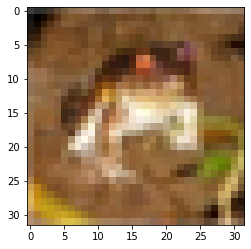

In [4]:
cifar10[0]
plt.imshow(cifar10[0][0].permute(1,2,0).numpy())

In [5]:
img, label = cifar10[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

In [6]:
pad_conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
out_pad = pad_conv(img.unsqueeze(0))
out_pad.shape

torch.Size([1, 16, 32, 32])

In [7]:
with torch.no_grad():
    pad_conv.bias.zero_()
    pad_conv.weight.fill_(1.0 / 9.0)

pad_conv.weight, pad_conv.bias

(Parameter containing:
 tensor([[[[0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111]],
 
          [[0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111]],
 
          [[0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111]]],
 
 
         [[[0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111]],
 
          [[0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111]],
 
          [[0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111]]],
 
 
         [[[0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111]],
 
          [[0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111],
           [0.1111, 0.1111, 0.1111]],
 
          [[0.1111, 0.1111, 0.1111],
           [0.1111, 0.

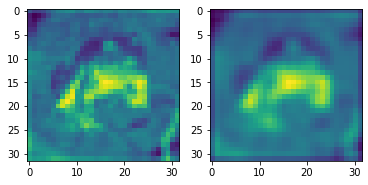

In [8]:
out_pad = pad_conv(img.unsqueeze(0))

fig, axs = plt.subplots(1,2)
axs[0].imshow(img.mean(dim=0)) # note that the conv has weights for each of the input channels
axs[1].imshow(out_pad[0, 0].detach())
plt.show()

In [9]:
blur1d = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    blur1d.weight[:] = torch.tensor(
        [[1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.]]
    )

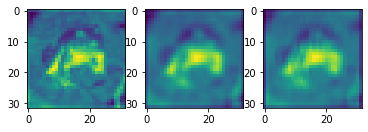

In [10]:
out_blur1 = blur1d(img.unsqueeze(0))
fig, axs = plt.subplots(1, 3)
axs[0].imshow(img.mean(dim=0))
axs[1].imshow(out_pad[0, 0].detach())
axs[2].imshow(out_blur1[0, 0].detach())
plt.show()

In [11]:
edge_detect = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    edge_detect.weight[:] = torch.tensor(
        [[-1., 0., 1.],
        [-1., 0., 1.],
        [-1., 0., 1.]]
    )

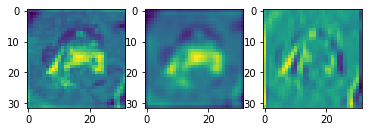

In [12]:
out_edge = edge_detect(img.unsqueeze(0))
fig, axs = plt.subplots(1, 3)
axs[0].imshow(img.mean(dim=0))
axs[1].imshow(out_pad[0, 0].detach())
axs[2].imshow(out_edge[0, 0].detach())
plt.show()

In [13]:
pool_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 10)
)

numel_list = [p.numel() for p in pool_model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

In [14]:
pool_model(img.unsqueeze(0))

tensor([[-0.1526,  0.2298,  0.1727,  0.0522, -0.1496, -0.0358,  0.1335,  0.1895,
         -0.1518, -0.0685]], grad_fn=<AddmmBackward0>)

In [15]:
class PoolModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)
        
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.flatten(out)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [16]:
import torch.nn.functional as F

class PoolNeat(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = torch.flatten(out, start_dim = 1) # in basic rather than Functional for some reason
        # lots of key functionals like flatten and tanh have been moved to torch core namespace
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out
    
# nn.Module class is a container for state in forms of Parameters and submodules in a forward function


In [17]:
model = PoolNeat()
model(img.unsqueeze(0))

full_cifar = [i for i, _ in cifar10]

In [18]:
imgs = torch.stack(full_cifar[:4])
type(imgs), imgs.shape
model(imgs)

tensor([[ 0.0409, -0.1623, -0.1202,  0.0545, -0.0870, -0.0197,  0.0726, -0.1733,
          0.0814, -0.1529],
        [ 0.0395, -0.1307, -0.1304,  0.0204, -0.0786, -0.0016,  0.0288, -0.1503,
          0.0820, -0.1724],
        [ 0.0277, -0.1691, -0.1295,  0.0192, -0.0241, -0.0390,  0.0530, -0.1552,
          0.0471, -0.1519],
        [ 0.0457, -0.1468, -0.1191,  0.0563, -0.0973, -0.0150,  0.0705, -0.1795,
          0.0687, -0.1586]], grad_fn=<AddmmBackward0>)

In [19]:
import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_path = './data/p1ch7'

cifar = datasets.CIFAR10(data_path, train=True, transform=transforms.ToTensor())
cifar_imgs = [img for img, val in cifar]
cifar_img_t = torch.stack(cifar_imgs)
cifar_img_t.shape

torch.Size([50000, 3, 32, 32])

In [20]:
channel_means = cifar_img_t.permute(1, 0, 2, 3).reshape(3, -1).mean(dim=1)
channel_stds = cifar_img_t.permute(1, 0, 2, 3).reshape(3, -1).std(dim=1)
channel_means, channel_stds

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [21]:
full_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])

In [22]:
cifar_tr_train = datasets.CIFAR10(data_path, train=True, transform=full_transform)
cifar_tr_val = datasets.CIFAR10(data_path, train=False, transform=full_transform)

In [23]:
train_loader = DataLoader(cifar_tr_train, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar_tr_val, batch_size=64, shuffle=True)

type(train_loader)

torch.utils.data.dataloader.DataLoader

In [24]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(n_epochs + 1):
        train_loss = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() #currently a torch.Tensor
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch: {}, Training loss: {}'.format(
                datetime.datetime.now(), epoch, 
                train_loss / len(train_loader)
            ))

In [25]:
model = PoolNeat()
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

In [26]:
training_loop(
    n_epochs=1,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2021-12-27 22:01:12.261930 Epoch: 0, Training loss: 2.0455404989554755
2021-12-27 22:01:30.514659 Epoch: 1, Training loss: 1.720213831385688


In [27]:
def validate(model, train_loader, val_loader):
    for name, loader in [('Train', train_loader), ('Validation', val_loader)]:
        total = 0
        correct = 0
        for imgs, labels in loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += outputs.shape[0]
            correct += int((predicted == labels).sum())
            
        print("{} accuracy: {:.2f}".format(name, correct / total)) 

validate(model, train_loader, val_loader)    

Train accuracy: 0.42
Validation accuracy: 0.42


In [28]:
from os import path
model_name = "cifar10model.pt"
torch.save(model.state_dict(), os.path.join(data_path, model_name))

In [29]:
loaded_model = PoolNeat() # Must not change the definition of the class
loaded_model.load_state_dict(torch.load(os.path.join(data_path, model_name)))

validate(loaded_model, train_loader, val_loader)

Train accuracy: 0.42
Validation accuracy: 0.42


In [30]:
import torch
torch.cuda.is_available()

False

In [31]:
class FancyPool(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_drop = nn.Dropout2d(p=0.4) # use 2d dropout which zeros out a whole feature at a time
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d(p=0.4)
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        assert x.shape[2] == 32
        assert x.shape[3] == 32
        
        
        out = F.max_pool2d(torch.tanh(self.conv1(x)))
        out = self.conv1_drop(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)))
        out = self.conv2_drop(out)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
    

In [32]:
x = {'x': lambda output: -1}
x['x']

<function __main__.<lambda>(output)>

In [33]:
def training_loop_l2reg(
    n_epochs,
    optimizer,
    model,
    loss_fn,
    device,
    train_loader,
    val_loader
):
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            class_loss = loss_fn(outputs, labels)
            l2loss = sum([p.pow(2.0).sum() for p in model.parameters()])
            loss = class_loss + l2loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += class_loss.item()
        
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch: {}, Training loss: {}'.format(
                datetime.datetime.now(), epoch,
                train_loss / len(train_loader)
            ))
            validate(model, train_loader, val_loader)
            
# note that SGD already has a weight decay parameter so can just use that
model_decay = FancyPool()
d_optimizer = torch.optim.SGD(model_decay.parameters(), lr=1e-2, weight_decay=0.001)
    

In [34]:
# What is batchnorm doing?
# It is normalizing the outputs of the batch, rescaling and moving so that
# they're around the non-linear portion of the activation function


class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
    

In [35]:
class ResNet(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.tanh(self.conv3(out)) + out1, 2)
        
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
# impacts of skip connections:
# improves convergence, esp initially
# loss landscape is much smoother        
        
        

In [36]:
# to build v deep blocks we need to define sub blocks

class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False) # batch norm would zero the bias anyway to its extraneous
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu') 
        # initialization, basically normal dist around 0
        # to copy the resnet paper exactly
        torch.nn.init.constant_(self.batch_norm.weight, 0.5) # this i think is the number of channels
        torch.nn.init.zeros_(self.batch_norm.bias) # this is the per channel bias
        
    def forward(self, x):
        out = self.conv(out)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x


In [37]:
class ResNetDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
# more care in intializations reflects the additional difficulty in 

In [ ]:
# Execises

# reading the conv2d docs
# there's grouping, where with a val of 3 there are three groups of channels which each
# only see a third of the input channels
# dilation spreads the pixels that the conv is looking at. produces a shrinking like with stride